<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/T651(not_predict_c620_mf_t651_mf).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
#!pip install autorch
import autorch

# config
use_pred_mf = False # 是否使用預測的 c620_mf,t651_mf

root = '/content/drive/MyDrive/台塑輕油案子/data/c620'

c620_col_names = joblib.load(root+'/col_names/c620_col_names.pkl')
t651_col_names = joblib.load(root+'/col_names/t651_col_names.pkl')

t651_df = pd.read_csv(root+'/cleaned/t651_train.csv',index_col=0)
c620_df = pd.read_csv(root+'/cleaned/c620_train.csv',index_col=0)

c620_x = c620_df[c620_col_names['sidedraw_x']]
t651_x = t651_df[t651_col_names['x41']]

t651_mfr = t651_df[t651_col_names['MFR']].iloc[:,0]
c620_mfr = pd.read_csv(root+'/cleaned/c620_mbcheck.csv',index_col=0).iloc[:,3]

total_mfr = c620_mfr +t651_mfr

c620_mf = c620_mfr / total_mfr
c620_mf = c620_mf.to_frame()
c620_mf.columns = ['c620_mf']

t651_mf = t651_mfr / total_mfr
t651_mf = t651_mf.to_frame()
t651_mf.columns = ['t651_mf']

In [2]:
mf_x = pd.concat([c620_x, t651_x], axis=1, sort=False)
print(mf_x.shape)
mf_x.sample(3)

(15552, 82)


,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Nitrogen_wt%,...,Extract Feed from T651_Detailed Composition_Methane_wt%,Extract Feed from T651_Detailed Composition_Ethane_wt%,Extract Feed from T651_Detailed Composition_Propane_wt%,Extract Feed from T651_Detailed Composition_n-Butane_wt%,Extract Feed from T651_Detailed Composition_n-Pentane_wt%,Extract Feed from T651_Detailed 

In [3]:
mf_y = pd.concat([c620_mf, t651_mf], axis=1, sort=False)
print(mf_y.shape)
mf_y.sample(3)

(15552, 2)


,c620_mf,t651_mf
007-024,0.551818,0.448182
034-026,0.359839,0.640161
142-105,0.358256,0.641744


In [4]:
np.any(np.isnan(mf_x)),np.any(np.isnan(mf_y))

(True, True)

In [5]:
x_col = mf_x.columns.tolist()
y_col = mf_y.columns.tolist()
clean_df = mf_x.join(mf_y).dropna(axis=0)
print(clean_df.shape)
clean_df.head(3)

(15547, 84)


,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Nitrogen_wt%,...,Extract Feed from T651_Detailed Composition_Propane_wt%,Extract Feed from T651_Detailed Composition_n-Butane_wt%,Extract Feed from T651_Detailed Composition_n-Pentane_wt%,Extract Feed from T651_Detailed Composition_n-Hexane_wt%,Extract Feed from T651_Detailed Composition_Benzene_wt%,Extract Feed from T651_Detaile

  0%|          | 1/300 [00:00<02:41,  1.85it/s]

epoch:0 train_loss:0.0224 valid_loss:0.0194


 17%|█▋        | 51/300 [00:28<02:14,  1.86it/s]

epoch:50 train_loss:0.0155 valid_loss:0.0160


 34%|███▎      | 101/300 [00:55<01:51,  1.78it/s]

epoch:100 train_loss:0.0150 valid_loss:0.0157


 50%|█████     | 151/300 [01:24<01:20,  1.84it/s]

epoch:150 train_loss:0.0146 valid_loss:0.0158


 67%|██████▋   | 201/300 [01:53<00:58,  1.68it/s]

epoch:200 train_loss:0.0145 valid_loss:0.0152


 84%|████████▎ | 251/300 [02:25<00:29,  1.64it/s]

epoch:250 train_loss:0.0144 valid_loss:0.0160


100%|██████████| 300/300 [02:56<00:00,  1.70it/s]


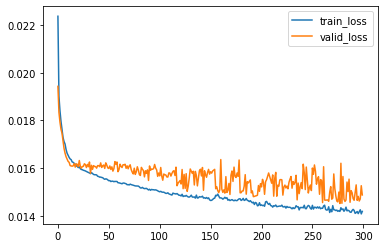

In [6]:
import autorch
model = autorch.utils.PartBulider(clean_df,
                                    x_col,
                                    y_col,
                                    normalize_idx_list=[[0,1]],
                                    hidden_size = 128,
                                    lr = 1e-3,
                                    max_epochs = 300)
model.train()

In [7]:
model.test()

,R2,MSE,MAPE
c620_mf,0.521789,0.00366109,12.0124
t651_mf,0.521789,0.00366109,7.80342
AVG,0.521789,0.00366109,9.90792


In [8]:
x_test = model.data['X_test']
y_real = model.data['Y_test']
y_pred = model.predict(x_test)
test_idx = x_test.index

In [9]:
y_real.head()

,c620_mf,t651_mf
005-019,0.334760,0.665240
063-073,0.423541,0.576459
048-008,0.270880,0.729120
112-008,0.325198,0.674802
035-038,0.313630,0.686370


In [10]:
y_pred.head()

,c620_mf,t651_mf
005-019,0.344555,0.655445
063-073,0.362337,0.637663
048-008,0.378400,0.621600
112-008,0.354428,0.645572
035-038,0.350354,0.649646


In [11]:
y_real.sum(axis=1).head()

005-019    1.0
063-073    1.0
048-008    1.0
112-008    1.0
035-038    1.0
dtype: float32

In [12]:
y_pred.sum(axis=1).head()

005-019    1.0
063-073    1.0
048-008    1.0
112-008    1.0
035-038    1.0
dtype: float32

In [13]:
c620_x = c620_x.loc[test_idx]
t651_x = t651_x.loc[test_idx]

if use_pred_mf:
  c620_mf = y_pred['c620_mf'].values.reshape(-1,1)
  t651_mf = y_pred['t651_mf'].values.reshape(-1,1)
else:
  c620_mf = c620_mf.loc[c620_x.index].values.reshape(-1,1)
  t651_mf = t651_mf.loc[t651_x.index].values.reshape(-1,1)

In [14]:
f = lambda x,m: x*m
temp1 = f(c620_x,c620_mf)
temp2 = f(t651_x,t651_mf)
temp2.columns = temp1.columns
mix_pred = temp1+temp2
mix_pred.head(3)

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Nitrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Oxygen_wt%
005-019,0.0,0.000135,0.008795,0.016353,0.011109,0.014842,0.020665,52.866228,0.012215,0.020267,0.0,0.015457,39.703220,0.037272,0.031892,0.026067,4.020333,0.817985,1.703132,0.470291,0.057088,1.706666e-07,0.126728,3.214962e-08,0.001472,0

In [15]:
c660_col_names = joblib.load(root+'/col_names/c660_col_names.pkl')
c660_x41_col = c660_col_names['x41']
c660_df = pd.read_csv(root+'/cleaned/c660_train.csv',index_col=0)
mix_real = c660_df[c660_x41_col]
mix_real.columns = mix_pred.columns
mix_real = mix_real.loc[test_idx,:]
mix_real.head(3)

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Nitrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Oxygen_wt%
005-019,0.0,0.000135,0.008795,0.016353,0.011109,0.014842,0.020665,52.866234,0.012215,0.020267,0.0,0.015457,39.703220,0.037272,0.031892,0.026067,4.020334,0.817985,1.703133,0.470291,0.057088,1.706666e-07,0.126728,3.214961e-08,0.001472,0

In [16]:
model.show_metrics(mix_real,mix_pred,e=1e-2).fillna(0)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,1.0,0.000000e+00,0.000000
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,1.0,5.949293e-22,0.000000
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,1.0,2.787263e-18,0.000015
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,1.0,9.164022e-18,0.000014
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,1.0,4.254480e-18,0.000015
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,1.0,6.692776e-18,0.000014
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,1.0,1.281013e-17,0.000014
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,1.0,7.505892e-11,0.000014
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,1.0,5.890087e-18,0.000014
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,1.0,1.785683e-17,0.000014


In [17]:
model.shrink()

In [18]:
joblib.dump(model,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_mf(82to2).pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_mf(82to2).pkl']